# 1. 向量链式法则

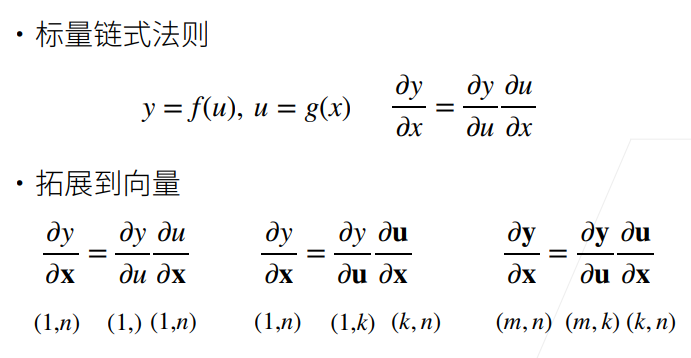

* 弄清楚形状之间的关系 

① 例子1是一个线性回归的例子，如下图所示。

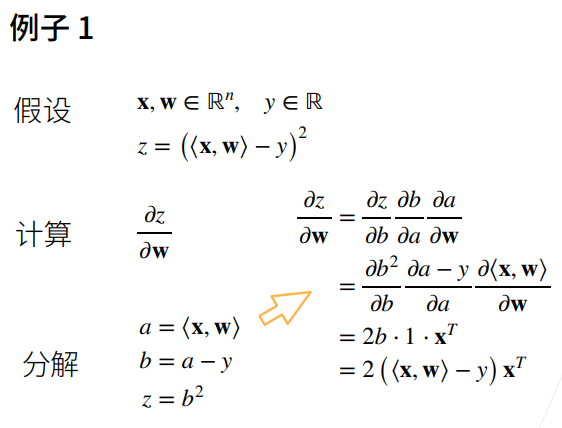

* X和W都是长度为n的向量，y是一个标量
* 先分解再链式法则

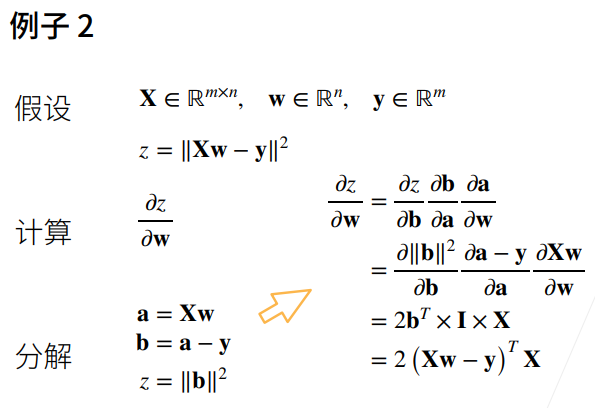

* 神经网络动不动就几百层？自动求导

# 2. 自动求导

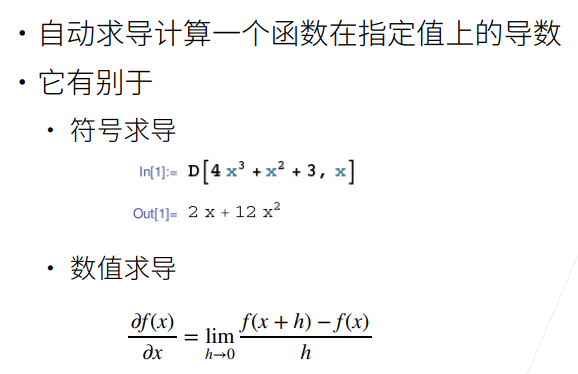

# 3. 计算图

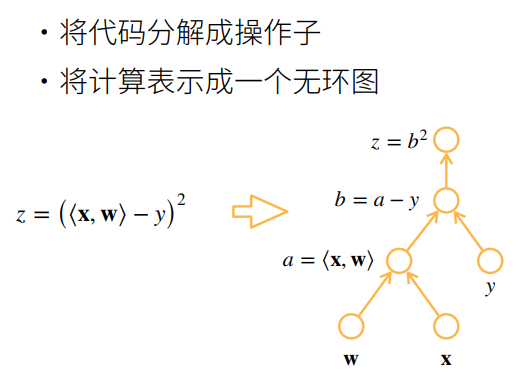

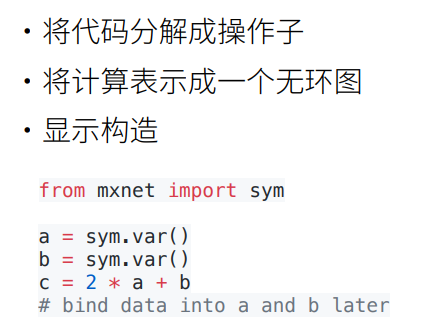

# 4. 两种模型

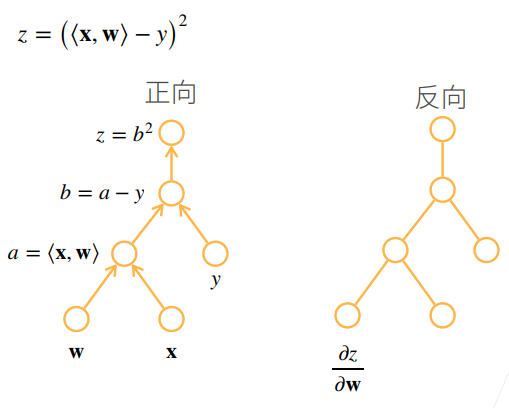

① b是之前计算的结果，是一个已知的值。

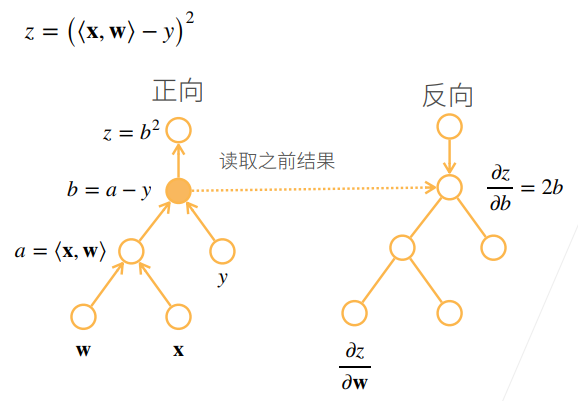

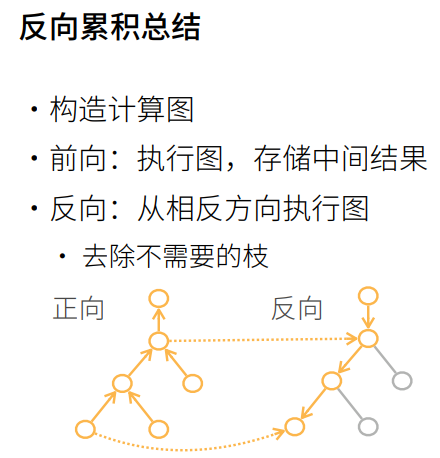

# 5. 复杂度

# 6. 自动求导

① 假设想对函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于列向量x求导。

In [1]:
import torch
x = torch.arange(4.0)
print(x)
print(x.shape)
print(x*x)
y = x.T
print(y)
print(y.shape)
print(torch.dot(x,x))

tensor([0., 1., 2., 3.])
torch.Size([4])
tensor([0., 1., 4., 9.])
tensor([0., 1., 2., 3.])
torch.Size([4])
tensor(14.)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19140\1653912563.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3641.)
  y = x.T


② 在外面计算y关于x的梯度之前，需要一个地方来存储梯度。

In [2]:
import torch
x = torch.arange(4.0)
x.requires_grad_(True) # 等价于 x = torch.arange(4.0,requires_grad=True)
print(x.grad) # 默认为None

None


In [3]:
import torch
x = torch.arange(4.0,requires_grad=True)
print(x.grad) # x.grad是存梯度的地方，默认为None，即还没有求导求出梯度出来

None


③ 现在计算y。

In [4]:
import torch
x = torch.arange(4.0,requires_grad=True)
y = 2 * torch.dot(x,x)
print(y) # grad_fn是隐式的构造了梯度函数

tensor(28., grad_fn=<MulBackward0>)


④ 通过调用反向传播函数来自动计算y关于x每个分量的梯度。

In [5]:
import torch
x = torch.arange(4.0,requires_grad=True)
y = 2 * torch.dot(x,x)
y.backward() # 反向传播后会有梯度计算出来
print(x.grad) # 访问导数，即访问梯度
print(x.grad == 4 * x) # 4 * x 是 2 * x * x 的导数

tensor([ 0.,  4.,  8., 12.])
tensor([True, True, True, True])


⑤ 计算x的另一个函数。

In [6]:
import torch
x = torch.arange(4.0,requires_grad=True)
y = 2 * torch.dot(x,x)
y.backward()
# 默认情况下，PyTorch会累积梯度，需要清除之前的值
x.grad.zero_() # y.backward() 后才能产生梯度，才能梯度清零，没有反向传播，无法梯度清零
y = x.sum() # 这里的y是一个标量，sum函数其实就是x_1+x_2+...x_n，求偏导自然是全1啊
print("y:",y)
y.backward()
print(x.grad)

y: tensor(6., grad_fn=<SumBackward0>)
tensor([1., 1., 1., 1.])


⑥ 在深度学习中，目的不是计算微分矩阵，而是批量中每个样本单独计算的偏导数之和。

In [40]:
import torch
x = torch.arange(4.0,requires_grad=True)
y = 2 * torch.dot(x,x)
y.backward()
print("y:",y)
print("x:",x)
print("x.grad:",x.grad)

# 默认情况下，PyTorch会累积梯度，需要清除之前的值
# 对非标量调用 'backward' 需要传入一个 'gradient' 参数，该参数指定微分函数
x.grad.zero_()
y = x * x  # 这里的y不是一个标量，这是一个向量
print("y:",y)
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward() # y.sum()后就将向量转为标量了，对标量求导
print("y.sum():",y.sum())
print("x.grad:",x.grad)
x.grad == 2 * x

x: tensor([0., 1., 2., 3.], requires_grad=True)
y: tensor(28., grad_fn=<MulBackward0>)
x.grad: tensor([ 0.,  4.,  8., 12.])
y: tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
y.sum(): tensor(14., grad_fn=<SumBackward0>)
x.grad: tensor([0., 2., 4., 6.])


tensor([True, True, True, True])

⑦ 将某些计算移动到记录的计算图之外。

In [8]:
import torch
x = torch.arange(4.0,requires_grad=True)
y = 2 * torch.dot(x,x)
y.backward()
x.grad.zero_()
y = x * x
print(y)
u = y.detach() # y.detach把y当作一个常数，而不是关于x的一个函数
print(y.detach())
print(u)
z = u * x
z.sum().backward()
x.grad == u

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
tensor([0., 1., 4., 9.])
tensor([0., 1., 4., 9.])


tensor([True, True, True, True])

**当你执行 u = y.detach() 时，实际上在 PyTorch 中发生了以下操作和概念：**

y 是一个由张量计算操作构建而成的张量，可能依赖于其他张量（如在你的例子中依赖于 x）。这些操作构成了一个计算图，用于跟踪张量之间的依赖关系以进行自动微分（计算梯度）。

detach() 方法用于从计算图中分离当前张量，这意味着它将脱离与计算图的任何关联。分离后的张量不再与原始计算图中的任何操作相关联，因此其梯度信息也不会再反向传播。这在一些情况下非常有用，例如将一个计算过程中的一部分标记为不需要梯度的常数项。

在你的例子中，y 是由 y = x * x 计算而来，它依赖于 x。当你执行 u = y.detach() 时，你创建了一个新的张量 u，它的值与 y 相同，但是它已经与原始计算图分离，不再与 x 或之前的操作相关联。

总结起来，u = y.detach() 将创建一个新的张量 u，该张量的值与 y 相同，但不再与计算图相关，因此它不会影响梯度计算。这在需要将某个张量视为常数，不需要进行梯度计算的情况下非常有用，例如在训练神经网络时冻结某些层的参数。

In [42]:
import torch
x = torch.arange(4.0,requires_grad=True)
y = 2 * torch.dot(x,x)
y.backward()
x.grad.zero_()
y = x * x  # 这里的y是关于x的函数
print("x.sum():",x.sum())
print("y.sum():",y.sum())
y.sum().backward()
x.grad == 2 * x

x.sum(): tensor(6., grad_fn=<SumBackward0>)
y.sum(): tensor(14., grad_fn=<SumBackward0>)


tensor([True, True, True, True])

* 如何理解这里的y.sum()?
对非标量调用 'backward' 需要传入一个 'gradient' 参数，该参数指定微分函数,y.sum()可以将y由向量转换成标量

⑧ 即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），仍然可以计算得到的变量的梯度。

In [46]:
def f(a):
    b = a * 2
    while b.norm() < 1000: # norm是L2范数
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(),requires_grad=True)
print(a)
d = f(a)
d.backward()
print(a.grad)
print(d/a)
a.grad == d/a # d是a的线性函数，所以导数就是斜率d/a

tensor(-0.8566, requires_grad=True)
tensor(204800.)
tensor(204800., grad_fn=<DivBackward0>)


tensor(True)


参考上边的方法，给出使用pytorch计算$y = 2{x_1} + 5{x_2} + {x_3} \times {x_3}$中梯度的程序

In [7]:
import torch

# 定义变量 x1, x2, x3，同时指定 requires_grad=True 以计算梯度
x1 = torch.tensor(3.0, requires_grad=True)
x2 = torch.tensor(4.0, requires_grad=True)
x3 = torch.tensor(2.0, requires_grad=True)

# 计算 y = 2x1 + 5x2 + x3^2
y = 2*x1 + 5*x2 + x3**2

# 执行反向传播，计算梯度
y.backward()

# 获取各个变量的梯度
grad_x1 = x1.grad
grad_x2 = x2.grad
grad_x3 = x3.grad

# 输出梯度值
print("Gradient of x1:", grad_x1.item())
print("Gradient of x2:", grad_x2.item())
print("Gradient of x3:", grad_x3.item())


Gradient of x1: 2.0
Gradient of x2: 5.0
Gradient of x3: 4.0
